## Data Prep

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from matplotlib import pyplot as plt 
import networkx as nx 
import pandas as pd 

In [2]:
from dotenv import load_dotenv
import os, sys

load_dotenv()

# Load PROJECT_ROOT
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add PROJECT_ROOT to sys.path
sys.path.append(PROJECT_ROOT)

In [3]:
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "routes_wps", "cs_2023-04-01.routes.csv"))
# Column names: flight_id	real_waypoints	pass_times	speeds	real_full_waypoints	full_pass_times	full_speeds
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _ih2EgzNc BIRES_29 _Nvk9jhMw _w8KvIFfJ _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _dDcVY6uy _h7pqh9t3 SOBOS_91 _ZMlbIPAH _TC...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _YO1GPJOe ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _UTQY1XAt _KrVEMEPH LUMED _jpa4X2Y4 _p30...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851


In [4]:
# Load the waypoints graph (nodes only)
ats_fra_graph = nx.read_gml(os.path.join(PROJECT_ROOT, "data", "graphs", "ats_fra_nodes_only.gml"))
print(f"ATS-FRA graph has {ats_fra_graph.number_of_nodes()} nodes and {ats_fra_graph.number_of_edges()} edges")

ATS-FRA graph has 33763 nodes and 0 edges


In [5]:
from utils.haversine import haversine_distance

# Function to extract first and last waypoints from the route
def get_first_last_waypoints(waypoints_str):
    waypoints = waypoints_str.split()
    if len(waypoints) < 2:
        return None, None
    return waypoints[0], waypoints[-1]

# Calculate the great circle distance for each route
def calculate_gc_distance(row):
    first_wp, last_wp = get_first_last_waypoints(row['real_waypoints'])
    
    if first_wp is None or last_wp is None:
        return np.nan
    
    try:
        # Get coordinates from the graph
        first_node = ats_fra_graph.nodes[first_wp]
        last_node = ats_fra_graph.nodes[last_wp]
        
        # Calculate distance
        distance = haversine_distance(
            first_node['lat'], first_node['lon'],
            last_node['lat'], last_node['lon']
        )
        return distance
    except KeyError:
        # Handle case where waypoint is not in the graph
        return np.nan

# Add the route_gc_length column to the dataframe
routes_df['route_gc_length'] = routes_df.apply(calculate_gc_distance, axis=1)
print(f'There are {len(routes_df)} routes in the routes_df')
# Display the first few rows with the new column
routes_df.head()


There are 22449 routes in the routes_df


,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _ih2EgzNc BIRES_29 _Nvk9jhMw _w8KvIFfJ _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _dDcVY6uy _h7pqh9t3 SOBOS_91 _ZMlbIPAH _TC...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _YO1GPJOe ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _UTQY1XAt _KrVEMEPH LUMED _jpa4X2Y4 _p30...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133


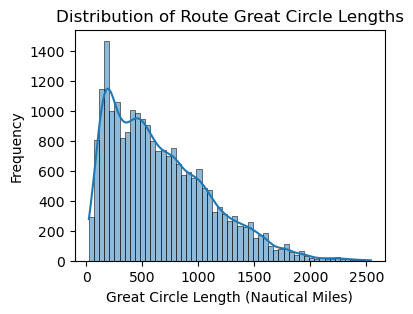

In [6]:
# Create a histogram of route great circle lengths using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.histplot(data=routes_df, x='route_gc_length', kde=True)
plt.title('Distribution of Route Great Circle Lengths')
plt.xlabel('Great Circle Length (Nautical Miles)')
plt.ylabel('Frequency')
plt.show()


## Adding ODs info

In [7]:
# From routes_df, add two columns: first_wp and last_wp
routes_df['first_wp'] = routes_df['real_waypoints'].str.split().str[0]
routes_df['last_wp'] = routes_df['real_waypoints'].str.split().str[-1]
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length,first_wp,last_wp
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803,INKIM,MALTI
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _ih2EgzNc BIRES_29 _Nvk9jhMw _w8KvIFfJ _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418,LAKTO,LCLK
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _dDcVY6uy _h7pqh9t3 SOBOS_91 _ZMlbIPAH _TC...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463,LCA,SISIM
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _YO1GPJOe ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254,TANSA_98,REXUN
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _UTQY1XAt _KrVEMEPH LUMED _jpa4X2Y4 _p30...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133,ODGAX,METRU_30


In [8]:
def get_grid_id(wp):
    """
    Get the grid ID for a waypoint based on its latitude and longitude.
    
    Args:
        wp (str): Waypoint name
    
    Returns:
        str: Grid ID in the format 'lat_lon'
    """
    try:
        node = ats_fra_graph.nodes[wp]
        lat = node['lat']
        lon = node['lon']
        
        lat_grid = int(lat / 0.5)
        lon_grid = int(lon / 0.5)
        
        return f"{lat_grid}:{lon_grid}"
    except KeyError:
        return np.nan

In [9]:
# Add the grid ID to each origin and destination
routes_df['origin_grid_id'] = routes_df['first_wp'].apply(get_grid_id)
routes_df['destination_grid_id'] = routes_df['last_wp'].apply(get_grid_id)
routes_df['od_id'] = routes_df['origin_grid_id'] + 'x' + routes_df['destination_grid_id']
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,alts,real_full_waypoints,full_pass_times,full_speeds,full_alts,route_gc_length,first_wp,last_wp,origin_grid_id,destination_grid_id,od_id
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114,439.718803,INKIM,MALTI,85:28,71:28,85:28x71:28
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434,LAKTO _ih2EgzNc BIRES_29 _Nvk9jhMw _w8KvIFfJ _...,1680362648 1680362639 1680362759 1680363659 16...,0.2708 0.2708 0.2365 0.1452 0.1359 0.1445 0.10...,9312 9312 9312 2499 1608 937 663 488 434 434,155.366418,LAKTO,LCLK,65:64,69:67,65:64x69:67
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257,LCA _dDcVY6uy _h7pqh9t3 SOBOS_91 _ZMlbIPAH _TC...,1680368182 1680368219 1680368279 1680368399 16...,0.1243 0.1243 0.1338 0.1648 0.1571 0.0000 0.0000,1265 1265 2019 3947 10249 10257 10257,180.431463,LCA,SISIM,69:67,64:64,69:67x64:64
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197,TANSA_98 METRU METRU_30 TOTTI LOTIN _YO1GPJOe ...,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000 0.0000,11133 11133 11133 11217 10150 5197 5197,610.653254,TANSA_98,REXUN,68:52,67:28,68:52x67:28
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851,ODGAX _UTQY1XAt _KrVEMEPH LUMED _jpa4X2Y4 _p30...,1680346619 1680346619 1680346679 1680347039 16...,0.2367 0.2367 0.2409 0.2639 0.2354 0.2515 0.00...,6568 6568 6949 8771 10843 10866 10851 10851,559.241133,ODGAX,METRU_30,67:27,68:50,67:27x68:50


In [10]:
origins = routes_df['origin_grid_id'].unique()
print(f'There are {len(origins)} unique origins in the routes_df, per {len(routes_df)} routes. Ratio: {len(origins)/len(routes_df)}')

There are 1409 unique origins in the routes_df, per 22449 routes. Ratio: 0.06276448839591964


## Some inspections

**Q.1:** How many edges are there in the graph?

In [11]:

def create_route_links(routes_df):
    # Initialize an empty dictionary to store links for each node
    links_dict = {}
    
    # Process each row in the dataframe
    for _, row in routes_df.iterrows():
        # Split the waypoints into a list
        waypoints = row['real_waypoints'].split()
        
        # Create pairs of consecutive waypoints
        for i in range(len(waypoints) - 1):
            from_wp = waypoints[i]
            to_wp = waypoints[i + 1]
            
            # Initialize empty sets for nodes if they don't exist
            if from_wp not in links_dict:
                links_dict[from_wp] = set()
            
            # Add unidirectional links
            links_dict[from_wp].add(to_wp)
    
    return links_dict

# Example usage:
links = create_route_links(routes_df)

# Count the total number of links in the graph
total_links = sum(len(destinations) for destinations in links.values())

print(f"Total links (counting both directions): {total_links}")

# Count how many nodes (waypoints) are in the graph
total_nodes = len(links)
print(f"Total nodes (waypoints) in the graph: {total_nodes}")

# Calculate the average number of connections per node
avg_connections = total_links / total_nodes if total_nodes > 0 else 0
print(f"Average connections per node: {avg_connections:.2f}")



Total links (counting both directions): 59573
Total nodes (waypoints) in the graph: 10651
Average connections per node: 5.59


In [12]:
# Find the hyper-connected nodes in the graph
def find_most_connected_node(links_dict):
    sorted_nodes = sorted(links_dict.keys(), key=lambda node: len(links_dict[node]), reverse=True)
    for i in range(10):
        print(f"{sorted_nodes[i]}: {len(links_dict[sorted_nodes[i]])}")
# Find and print the most hyper-connected node
print(f'Top 10 most connected nodes:')
find_most_connected_node(links)


Top 10 most connected nodes:
BCN_84: 138
FATIH: 133
ESSA: 109
LFPB: 106
MOVUM: 105
RESMI: 104
DUB: 97
EPWA: 97
BCN: 94
EGLL: 84


## Create a NX graph

In [13]:
from utils.haversine import haversine_distance
# Create a new graph from the existing ATS graph
GX = ats_fra_graph.copy()

# Add all the links from our links dictionary to the graph
for from_wp, to_wps in links.items():
    for to_wp in to_wps:
        # Compute the attributes
        distance = haversine_distance(GX.nodes[from_wp]['lat'], GX.nodes[from_wp]['lon'],
                                      GX.nodes[to_wp]['lat'], GX.nodes[to_wp]['lon'])
        GX.add_edge(from_wp, to_wp, distance = distance)

print(f"Graph now has {GX.number_of_nodes()} nodes and {GX.number_of_edges()} edges")


Graph now has 33763 nodes and 58202 edges


# Gradient Descent 

First, we test whether the computational time is feasible!

In [14]:
from ppl.bellman_ford import initialize_preference_scores, optimize_preferences
GXX = GX.copy() # create a copy of the graph
# Convert GXX to a DiGraph
# Convert GXX to a directed graph
GXX = nx.DiGraph(GXX)
initialize_preference_scores(GXX)

In [15]:
# Find all origins with at least 10 demonstrations from routes_df
admitted_origins = []
for origin in origins:
    routes_df_origin = routes_df[routes_df['origin_grid_id'] == origin]
    if len(routes_df_origin) < 10:
        continue
    admitted_origins.append(origin)
print(f'Number of origins with at least 10 demonstrations is {len(admitted_origins)}')

Number of origins with at least 10 demonstrations is 300


## Compute Soft Value Function for Each Origin

We will measure how quickly we can compute the soft value functions of the entire large graph.

In [16]:
GXX = GX.copy()
GXX = nx.DiGraph(GXX)

In [17]:
from bellman_ford_sparse1000 import compute_edge_costs_dict, graph_to_sparse_matrices
import time 

start_time = time.time()
costs_dict = compute_edge_costs_dict(GXX, 1.0)
print(f"Time taken to compute edge costs: {time.time() - start_time} seconds")
start_time = time.time()
A_mat, costs_mat, node_mapping = graph_to_sparse_matrices(GXX, costs_dict)
print(f"Time taken to convert graph to sparse matrices: {time.time() - start_time} seconds")


V_k:            [0.5 1.  1.5 2. ]
V_new (Sparse): [2.6        0.6        0.26251205 0.96251205]
Time taken to compute edge costs: 0.11036205291748047 seconds
Time taken to convert graph to sparse matrices: 0.07908487319946289 seconds


In [34]:
node_from = 'LFPG'
# Find the index of the node_from in the node_mapping
for idx, node in node_mapping.items():
    if node == node_from:
        node_from_idx = idx
        break

print(f"Node {node_from} has index {node_from_idx}")

# Find all nodes that have a direct edge from node_from
successors = list(GXX.successors(node_from))
print(f"Number of direct successors from {node_from}: {len(successors)}")
print(f"Direct successors: {successors[:10]}..." if len(successors) > 10 else f"Direct successors: {successors}")

# Find the indices of these successors in the node_mapping
successor_indices = []
for node in successors:
    for idx, mapped_node in node_mapping.items():
        if mapped_node == node:
            successor_indices.append(idx)
            break

print(f"Number of successor indices: {len(successor_indices)}")
print(f"Successor indices: {successor_indices[:10]}..." if len(successor_indices) > 10 else f"Successor indices: {successor_indices}")

# Verify these edges in the sparse matrix
edge_exists = []
for idx in successor_indices:
    if A_mat[node_from_idx, idx] != 0:
        edge_exists.append((node_from_idx, idx))

print(f"Number of verified edges in sparse matrix: {len(edge_exists)}")
print(f"Verified edges (source_idx, target_idx): {edge_exists[:10]}..." if len(edge_exists) > 10 else f"Verified edges: {edge_exists}")



Node LFPG has index 27409
Number of direct successors from LFPG: 102
Direct successors: ['CSO', 'DVL', 'RONAX', 'BAVOL', 'DIKOL', 'CTL', 'OXOTO', 'NEPAR', 'MOPAR', 'VEPET']...
Number of successor indices: 102
Successor indices: [231, 237, 404, 427, 652, 981, 1225, 1286, 1308, 1321]...
Number of verified edges in sparse matrix: 102
Verified edges (source_idx, target_idx): [(27409, 231), (27409, 237), (27409, 404), (27409, 427), (27409, 652), (27409, 981), (27409, 1225), (27409, 1286), (27409, 1308), (27409, 1321)]...


In [45]:
from bellman_ford_sparse1000 import bellman

start_time = time.time()
V_k = bellman(A_mat, costs_mat, node_from_idx)
print(f"Time taken to compute soft value function: {time.time() - start_time} seconds")

Time taken to compute soft value function: 0.38337206840515137 seconds


V_k[node_from_idx]: 0.0
V_k[CSO]: 23.025850929940457; Distance: 783.971722105914
V_k[DVL]: 23.025850929723166; Distance: 89.593743049039
V_k[RONAX]: 23.02585092993942; Distance: 93.48460223974539
V_k[BAVOL]: 23.025849787639043; Distance: 44.20107735591085
V_k[DIKOL]: 23.025833512574327; Distance: 59.54763416298446
V_k[CTL]: 23.025695262151235; Distance: 41.23091805808308
V_k[OXOTO]: 23.02585092526516; Distance: 65.59620478267057
V_k[NEPAR]: 23.025059719159273; Distance: 39.73766111522308
V_k[MOPAR]: 23.025846472802087; Distance: 35.36035569837336
V_k[VEPET]: 23.025850929940457; Distance: 58.687970290361136
V_k[UNGAP]: 22.941001068592538; Distance: 250.7296408606454
V_k[LISMO]: 23.025850929940457; Distance: 182.66148354076014
V_k[DINOX]: 23.025850929940457; Distance: 201.2346282356341
V_k[SAPRE]: 23.008241996266126; Distance: 219.20992046191256
V_k[EKROS]: 23.022206352694287; Distance: 209.21366268040762
V_k[LOHRE]: 23.025804178388647; Distance: 277.5860719981297
V_k[PITES]: 23.02575734

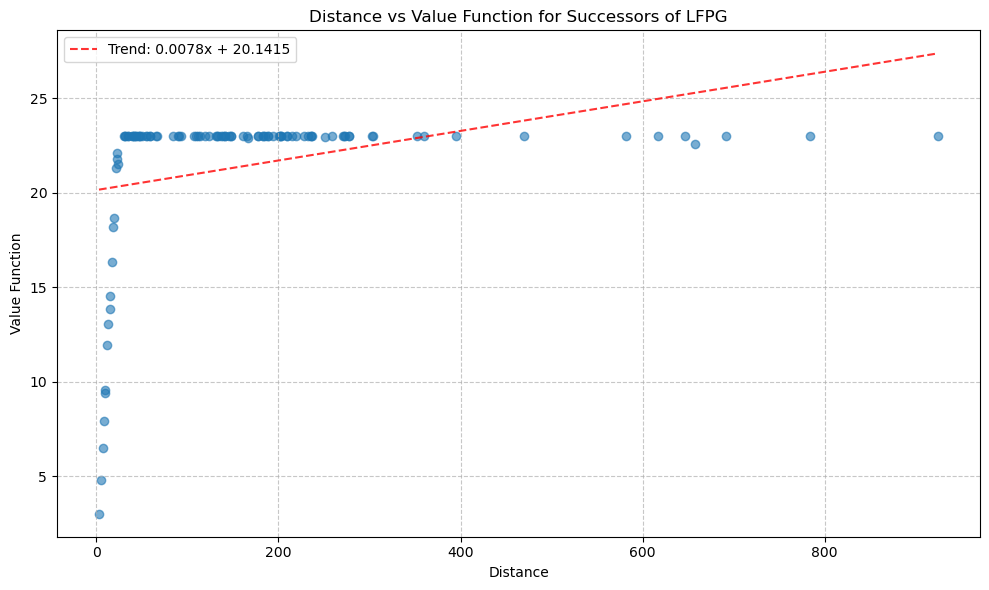

Correlation coefficient between distance and value: 0.3269


In [47]:
print(f"V_k[node_from_idx]: {V_k[node_from_idx]}")
reverse_node_mapping = {v: k for k, v in node_mapping.items()}
V_successors = []

for idx in successor_indices:
    print(f"V_k[{node_mapping[idx]}]: {V_k[idx]}; Distance: {costs_dict[(node_from, node_mapping[idx])]}")
    
# Create a list of (distance, value) pairs for plotting
distance_value_pairs = []
for idx in successor_indices:
    node = node_mapping[idx]
    distance = costs_dict[(node_from, node)]
    value = V_k[idx]
    distance_value_pairs.append((distance, value))

# Sort by distance for better visualization
distance_value_pairs.sort(key=lambda x: x[0])

# Extract distances and values for plotting
distances = [pair[0] for pair in distance_value_pairs]
values = [pair[1] for pair in distance_value_pairs]

# Plot distance vs value function
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(distances, values, alpha=0.6)
plt.xlabel('Distance')
plt.ylabel('Value Function')
plt.title(f'Distance vs Value Function for Successors of {node_from}')
plt.grid(True, linestyle='--', alpha=0.7)

# Add a trend line
if len(distances) > 1:
    import numpy as np
    z = np.polyfit(distances, values, 1)
    p = np.poly1d(z)
    plt.plot(distances, p(distances), "r--", alpha=0.8, label=f"Trend: {z[0]:.4f}x + {z[1]:.4f}")
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation coefficient
if len(distances) > 1:
    import numpy as np
    correlation = np.corrcoef(distances, values)[0, 1]
    print(f"Correlation coefficient between distance and value: {correlation:.4f}")


**Important Question:** When performing MaxEntIL, can we perform an ordered gradient descent? Like by one origin demonstrations after another? For a common edge shared between many origin demonstration sets, if the edge was not used by the previous demonstration batch, but heavily used by this demonstration batch, does it change anything?

**TL;DR:** Yes we can do gradient descent as normal, but we need to be careful about the learning rate for each origin. Mathematically, it will be the same.

See: https://aistudio.google.com/u/2/prompts/1Vt1BVrfG7mlCn691vP3VjmDRY3DRQBtX

**Next Steps:** 
1. Perform a full gradient descent loop with simple preference model to check the computational feasibility.
1. Check the negative log-likelihood.
1. Gradually introduce other factors like weather, wind into the objective function.
1. Then introduce the adjacent sector/block graph.
1. Finally, introduce a neural network for long-term dependency.

Remember: scale will lead to emergent behaviors.

In [ ]:
origin_counter